In [1]:
!pip install opencv-python numba

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


(211, 350, 3)


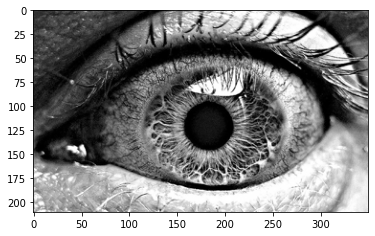

In [2]:
import cv2
import requests
import matplotlib.pyplot as plt
import numpy as np
from numba import cuda

r = requests.get('http://i.stack.imgur.com/397vv.png', allow_redirects=True)
open('397vv.png', 'wb').write(r.content)
test_image = cv2.imread('397vv.png')

print(test_image.shape)

imgplot = plt.imshow(test_image)
plt.show()

In [3]:
@cuda.jit
def cv_histogram(image, grayscale_image):
    y,x = cuda.grid(2)
    
    if x < image.shape[0] and y < image.shape[1]:
        grayscale_image[x,y] = 0.2126*image[x,y,0] + 0.7152*image[x,y,1] + 0.0722*image[x,y,2]

In [4]:
threadsperblock = 32
xblocks = (test_image.shape[1] + (threadsperblock - 1)) // threadsperblock
yblocks = (test_image.shape[0] + (threadsperblock - 1)) // threadsperblock

print("Xblocks: ", xblocks)
print("Yblocks: ", yblocks)

Xblocks:  11
Yblocks:  7


In [5]:
def conv_cpu(image, kernel, kernel_size, output):
  for x in range(image.shape[0]):
    for y in range(image.shape[1]):
      if x + kernel_size < image.shape[0] and y + kernel_size < image.shape[1]:
        sum = 0
        for i in range(kernel_size):
            for j in range(kernel_size):
                sum += kernel[i,j] * image[x + i, y + j]
        output[x,y] = sum

@cuda.jit
def conv_cuda(image, kernel, kernel_size, output):
    y,x = cuda.grid(2)
    if x + kernel_size < image.shape[0] and y + kernel_size < image.shape[1]:
        sum = 0
        for i in range(kernel_size):
            for j in range(kernel_size):
                sum += kernel[i,j] * image[x + i, y + j]
        output[x,y] = sum



In [6]:
gray_img = np.zeros(shape=(test_image.shape[0], test_image.shape[1]), dtype=np.uint8)

blocks_per_grid = (xblocks, yblocks)

cv_histogram[blocks_per_grid, (threadsperblock, threadsperblock)](test_image, gray_img)

gray_img.shape

(211, 350)

Blur Box kernel
[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]
CPU Time:
923 ms ± 4.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GPU Time:
1.46 ms ± 161 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


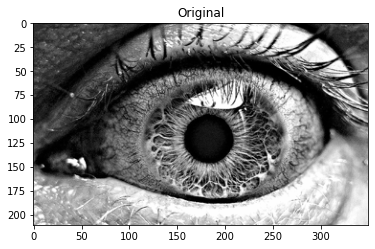

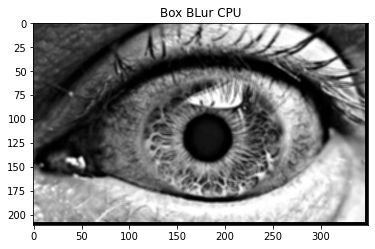

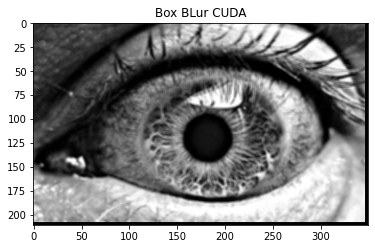

In [7]:
output_cpu = np.zeros(shape=(test_image.shape[0], test_image.shape[1]), dtype=np.uint8)
output_cuda = np.zeros(shape=(test_image.shape[0], test_image.shape[1]), dtype=np.uint8)

print('Blur Box kernel')
kernel_blur = (np.ones(9)/9).reshape(3,3)
print(kernel_blur)

print('CPU Time:')
%timeit conv_cpu(gray_img, kernel_blur, kernel_blur.shape[0], output_cpu)

print('GPU Time:')
%timeit conv_cuda[blocks_per_grid, (threadsperblock, threadsperblock)](gray_img, kernel_blur, kernel_blur.shape[0], output_cuda)

plt.figure()
plt.title('Original')
plt.imshow(gray_img, cmap="gray", vmin=0, vmax=255)

plt.figure()
plt.title('Box BLur CPU')
plt.imshow(output_cpu, cmap='gray')

plt.figure()
plt.title('Box BLur CUDA')
plt.imshow(output_cuda, cmap='gray')

